## STAT5 Dimerization Model

The goal of the notebook is estimate Confidence Bands of [STAT5 Dimerization](doi:10.1021/pr5006923) Model with *LikelihoodProfiler*. STAT5 Dimerization is one of the Benchmark models for [dMod R package](https://github.com/dkaschek/dMod). We have translated the model to [Julia language](https://julialang.org/). [dMod BenchmarkModels repo](https://github.com/dkaschek/dMod/tree/master/BenchmarkModels/Boehm_JProteomeRes2014) contains the model files, experimental data and best-fit parameters.
The model is defined by the following system of differential equations:

In [1]:
using DiffEqBase, OrdinaryDiffEq, CSV, DataFrames, LikelihoodProfiler
using Plots

# constants
const cyt = 1.4
const nuc = 0.45
const ratio = 0.693
const specC17 = 0.107


# ode system
function stat5_ode(du, u, p, time)
    # 8 states:
    (STAT5A, pApA, STAT5B, pApB, pBpB, nucpApA, nucpApB, nucpBpB) = u
    # 6 parameters
    (Epo_degradation_BaF3, k_exp_hetero, k_exp_homo, k_imp_hetero, k_imp_homo, k_phos) =  p
    
    BaF3_Epo = 1.25e-7*exp(-1*Epo_degradation_BaF3*time)

    v1 = BaF3_Epo*(STAT5A^2)*k_phos
    v2 = BaF3_Epo*STAT5A*STAT5B*k_phos
    v3 = BaF3_Epo*(STAT5B^2)*k_phos
    v4 = k_imp_homo*pApA
    v5 = k_imp_hetero*pApB
    v6 = k_imp_homo*pBpB
    v7 = k_exp_homo*nucpApA
    v8 = k_exp_hetero*nucpApB
    v9 = k_exp_homo*nucpBpB

    du[1] = -2*v1 - v2 + 2*v7*(nuc/cyt) + v8*(nuc/cyt)
    du[2] = v1 - v4
    du[3] = -v2 -2*v3 + v8*(nuc/cyt) + 2*v9*(nuc/cyt)
    du[4] = v2 - v5
    du[5] = v3 - v6
    du[6] = v4*(cyt/nuc) - v7
    du[7] = v5*(cyt/nuc) - v8
    du[8] = v6*(cyt/nuc) - v9
end;

Let's load the experimental dataset 

In [2]:
data = CSV.read("data_stat5.csv", DataFrame);

Observables, initial values and solver settings are set according to [model's files](https://github.com/dkaschek/dMod/tree/master/BenchmarkModels/Boehm_JProteomeRes2014) and [dMod settings](https://github.com/dkaschek/dMod/blob/master/R/PEtab2dMod.R)

In [3]:
saveat = Float64.(data[!,:time])
tspan = (0.,saveat[end])

u0 = zeros(8)
u0[1] = 207.6*ratio         # STAT5A
u0[3] = 207.6 - 207.6*ratio # STAT5B

prob(p) = ODEProblem(stat5_ode, eltype(p).(u0), tspan, p)

function solve_prob(p)
    _prob = prob(p)

    # solution
    sol = solve(_prob, AutoTsit5(Rosenbrock23()), saveat=saveat, reltol=1e-3,abstol=1e-6) #save_idxs=[1,2,3,4,5] 
    STAT5A = sol[1,:]
    pApA = sol[2,:]
    STAT5B = sol[3,:]
    pApB = sol[4,:]
    pBpB = sol[5,:]

    # observables
    pSTAT5A_rel = (100 * pApB + 200 * pApA * specC17) ./ (pApB + STAT5A * specC17 + 2 * pApA * specC17)
    pSTAT5B_rel = -(100 * pApB - 200 * pBpB * (specC17 - 1)) ./ ((STAT5B * (specC17 - 1) - pApB) + 2 * pBpB * (specC17 - 1))
    rSTAT5A_rel = (100 * pApB + 100 * STAT5A * specC17 + 200 * pApA * specC17) ./ (2 * pApB + STAT5A * specC17 + 2 * pApA * specC17 - STAT5B * (specC17 - 1) - 2 * pBpB * (specC17 - 1))

    return [pSTAT5A_rel, pSTAT5B_rel, rSTAT5A_rel]
end;

The [best-fit](https://github.com/dkaschek/dMod/blob/master/BenchmarkModels/Boehm_JProteomeRes2014/parameters_Boehm_JProteomeRes2014.tsv) parameters values:

In [4]:
p_best = [
    0.026982514033029,      # Epo_degradation_BaF3
    0.0000100067973851508,  # k_exp_hetero
    0.006170228086381,      # k_exp_homo
    0.0163679184468,        # k_imp_hetero
    97749.3794024716,       # k_imp_homo
    15766.5070195731,       # k_phos
    3.85261197844677,       # sd_pSTAT5A_rel
    6.59147818673419,       # sd_pSTAT5B_rel
    3.15271275648527        # sd_rSTAT5A_rel
];

Let's run the simulations and plot results for best-fit parameters values

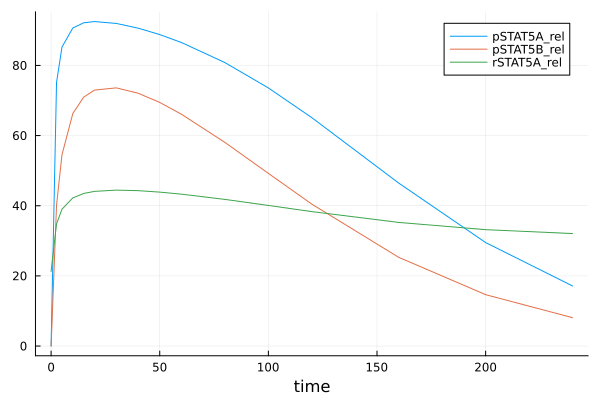

In [5]:
sol = solve_prob(p_best)
plot(saveat,sol, label=["pSTAT5A_rel" "pSTAT5B_rel" "rSTAT5A_rel"], xlabel=:time)

Loss function includes parameters transformation to log10 scale:

In [6]:
function loss_func(p_init)
    p = exp10.(p_init)

    sim = solve_prob(p)
    σ = p[7:9]
    # loss
    return loss(sim,data,σ)
end

function loss(sim,data,σ)
    loss = 0.0
    obs = names(data)[2:end]  

    for i in 1:length(obs)
        loss_i = loss_component(sim[i],data[!,i+1],σ[i])
        loss += loss_i
    end
    return loss
end

function loss_component(sim,data,σ)
    loss_i = 0.0
    
    for i in eachindex(sim)
            loss_i += ((sim[i]-data[i])/σ)^2 + 2*log(sqrt(2π)*σ)
    end
    return loss_i
end;

Now we are ready to estimate Confidence Bands with *LikelihoodProfiler*

In [7]:
α = loss_func(log10.(p_best)) + 3.84 # chisq with 1 df

# search CI with LikelihoodProfiler
num_params = length(p_best)
p_log = log10.(p_best)

function bands_pSTAT5A(parampampam, i)
    p = exp10.(parampampam)
    sol = solve_prob(p)
    sol[1][i]
end

function bands_pSTAT5B(parampampam, i)
    p = exp10.(parampampam)
    sol = solve_prob(p)
    sol[2][i]
end

function bands_rSTAT5A(parampampam, i)
    p = exp10.(parampampam)
    sol = solve_prob(p)
    sol[3][i]
end

tbounds = fill((-6.,6.), num_params)
sbounds = (-3.,120.);

*Confidence bands* for pSTAT5A:

In [8]:
intervals = Vector{ParamInterval}(undef,length(saveat))
for i in eachindex(saveat)
    @time intervals[i] = get_interval(
        p_log,
        p->bands_pSTAT5A(p,i),
        loss_func,
        :CICO_ONE_PASS,
        loss_crit = α,
        theta_bounds = tbounds,
        scan_bounds = sbounds,
        scan_tol = 1e-2,
        local_alg = :LN_NELDERMEAD,
    )
end

  1.765648 seconds (2.29 M allocations: 149.597 MiB, 3.54% gc time, 93.57% compilation time)
  0.949774 seconds (782.47 k allocations: 81.962 MiB, 2.76% gc time)
  2.034964 seconds (2.00 M allocations: 208.984 MiB, 1.32% gc time)
  0.491536 seconds (510.81 k allocations: 53.547 MiB, 0.59% gc time)
  0.300008 seconds (282.60 k allocations: 29.648 MiB)
  1.082263 seconds (971.62 k allocations: 101.818 MiB, 0.54% gc time)
  0.771580 seconds (762.75 k allocations: 79.958 MiB, 0.31% gc time)
  1.574826 seconds (1.71 M allocations: 179.292 MiB, 0.57% gc time)
  1.270771 seconds (1.38 M allocations: 144.190 MiB, 0.42% gc time)
  1.318409 seconds (1.39 M allocations: 145.413 MiB, 0.69% gc time)
  1.932135 seconds (1.98 M allocations: 207.400 MiB, 0.41% gc time)
  1.703312 seconds (1.58 M allocations: 165.065 MiB, 0.60% gc time)
  1.458444 seconds (1.45 M allocations: 151.595 MiB, 0.66% gc time)
  2.074422 seconds (2.14 M allocations: 224.027 MiB, 0.37% gc time)
  1.606882 seconds (1.76 M alloc

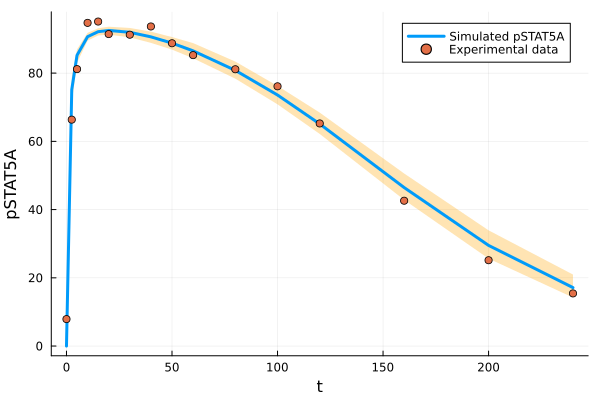

In [9]:
lbands = [iv.result[1].value for iv in intervals]
ubands = [iv.result[2].value for iv in intervals]
u = sol[1]

plot(saveat, u, xlabel = "t", ylabel = "pSTAT5A", label="Simulated pSTAT5A", line=3,
ribbon = (u-lbands, ubands-u), fc=:orange, fa=0.3);
scatter!(data.time, data.pSTAT5A_rel, label = "Experimental data")

*Confidence bands* for pSTAT5B:

In [10]:
intervals = Vector{ParamInterval}(undef,length(saveat))
for i in eachindex(saveat)
    @time intervals[i] = get_interval(
        p_log,
        p->bands_pSTAT5B(p,i),
        loss_func,
        :CICO_ONE_PASS,
        loss_crit = α,
        theta_bounds = tbounds,
        scan_bounds = sbounds,
        scan_tol = 1e-2,
        local_alg = :LN_NELDERMEAD,
    )
end

  0.776451 seconds (740.50 k allocations: 48.824 MiB, 2.43% gc time, 85.55% compilation time)
  1.603559 seconds (1.74 M allocations: 182.148 MiB, 2.24% gc time)
  2.371577 seconds (1.77 M allocations: 185.724 MiB, 0.33% gc time)
  1.954136 seconds (1.74 M allocations: 182.417 MiB, 0.39% gc time)
  2.199190 seconds (2.13 M allocations: 223.357 MiB, 0.51% gc time)
  1.624655 seconds (1.67 M allocations: 175.099 MiB, 0.34% gc time)
  2.018404 seconds (2.08 M allocations: 218.125 MiB, 0.57% gc time)
  1.759458 seconds (1.87 M allocations: 195.911 MiB, 0.47% gc time)
  1.674893 seconds (1.63 M allocations: 170.329 MiB, 0.53% gc time)
  1.242284 seconds (1.23 M allocations: 129.344 MiB, 0.48% gc time)
  1.950532 seconds (1.97 M allocations: 206.837 MiB, 0.67% gc time)
  1.662904 seconds (1.61 M allocations: 168.531 MiB, 0.40% gc time)
  1.417832 seconds (1.46 M allocations: 153.107 MiB, 0.67% gc time)
  2.004324 seconds (1.98 M allocations: 207.657 MiB, 0.48% gc time)
  1.104988 seconds (1.

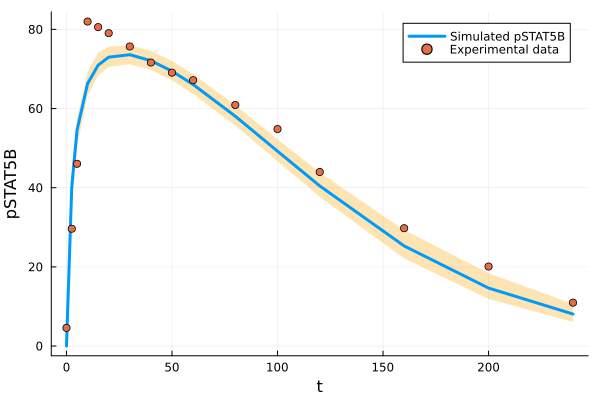

In [11]:
lbands = [iv.result[1].value for iv in intervals]
ubands = [iv.result[2].value for iv in intervals]
u = sol[2]

plot(saveat, u, xlabel = "t", ylabel = "pSTAT5B", label="Simulated pSTAT5B", line=3,
ribbon = (u-lbands, ubands-u), fc=:orange, fa=0.3);
scatter!(data.time, data.pSTAT5B_rel, label = "Experimental data")

*Confidence bands* for rSTAT5A:

In [12]:
intervals = Vector{ParamInterval}(undef,length(saveat))
for i in eachindex(saveat)
    @time intervals[i] = get_interval(
        p_log,
        p->bands_rSTAT5A(p,i),
        loss_func,
        :CICO_ONE_PASS,
        loss_crit = α,
        theta_bounds = tbounds,
        scan_bounds = sbounds,
        scan_tol = 1e-2,
        local_alg = :LN_NELDERMEAD,
    )
end

  0.745735 seconds (740.50 k allocations: 48.826 MiB, 2.19% gc time, 84.67% compilation time)
  0.757227 seconds (785.56 k allocations: 82.382 MiB, 2.66% gc time)
  0.482251 seconds (524.57 k allocations: 54.986 MiB, 2.46% gc time)
  1.268236 seconds (1.22 M allocations: 127.861 MiB, 0.45% gc time)
  0.273955 seconds (282.80 k allocations: 29.672 MiB, 0.99% gc time)
  1.274807 seconds (1.35 M allocations: 140.943 MiB, 0.47% gc time)
  0.534687 seconds (501.88 k allocations: 52.651 MiB, 0.52% gc time)
  0.424167 seconds (498.35 k allocations: 52.238 MiB, 0.78% gc time)
  0.771582 seconds (768.98 k allocations: 80.629 MiB, 0.40% gc time)
  1.169201 seconds (1.26 M allocations: 132.318 MiB, 0.49% gc time)
  0.849435 seconds (901.97 k allocations: 94.552 MiB, 0.75% gc time)
  1.153412 seconds (1.15 M allocations: 120.785 MiB, 0.49% gc time)
  1.164975 seconds (1.17 M allocations: 122.353 MiB, 0.55% gc time)
  1.534501 seconds (1.69 M allocations: 176.689 MiB, 0.61% gc time)
  1.787590 seco

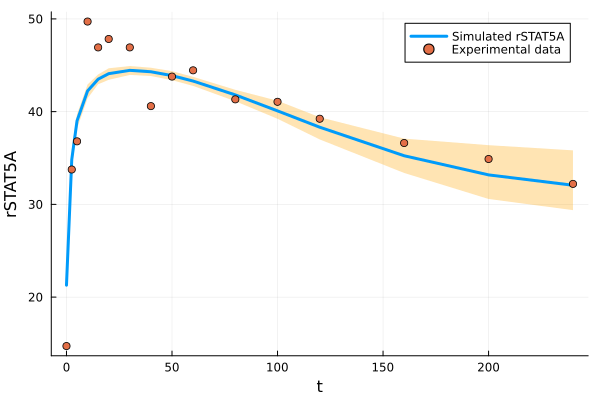

In [13]:
lbands = [iv.result[1].value for iv in intervals]
ubands = [iv.result[2].value for iv in intervals]
u = sol[3]

plot(saveat, u, xlabel = "t", ylabel = "rSTAT5A", label="Simulated rSTAT5A", line=3,
ribbon = (u-lbands, ubands-u), fc=:orange, fa=0.3);
scatter!(data.time, data.rSTAT5A_rel, label = "Experimental data")